# Quantile based crunchers
There are three main quantile-based crunchers: the Equal Quantile Walk cruncher (EQW), which is most comparable with existing methods in the literature (e.g. 'Multi-gas emissions pathways to meet climate targets', Meinshausen et al 2006); the Extend Latest Time Quantile, which applies the same logic as the EQW but extends the time period of the latest emission to the latest time in the infiller database; and the Quantile Rolling Windows cruncher, which provides a closer represenation of the relationships between variables. There is also a modified form of the latter, called the Time-Dependent Quantile Rolling Windows cruncher. This is identical, except that the standard implementation has the same quantile for each time, whereas this implementation allows each time period to use a different quantile. 

## Collecting data
We import functions and get data from the IIASA database as in earlier notebooks.

In [1]:
import traceback
import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

import silicone.database_crunchers
from silicone.stats import rolling_window_find_quantiles
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    _make_interpolator,
    _make_wide_db,
    get_sr15_scenarios,
    download_or_load_sr15,
)

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
valid_model_ids = [
    "MESSAGE*",
    "AIM*",
    "C-ROADS*",
    "GCAM*",
    "WITCH*",
]
sr15_data = download_or_load_sr15("./sr15_scenarios.csv", valid_model_ids)

pyam.core - INFO: Reading file `./sr15_scenarios.csv`


# Equal Quantile Walk cruncher
This cruncher assumes that the amount of effort in reducing one set of emissions will match that in another set, and therefore the emissions will occur at similar quantiles in the database. It is the method used in many previous papers on infilling, e.g. "Multi-gas emissions pathways to meet climate targets", Meinshausen et al. 2006. 

In [3]:
print(silicone.database_crunchers.EqualQuantileWalk.__doc__)


    Database cruncher which uses the 'equal quantile walk' technique.

    This cruncher assumes that the amount of effort going into reducing one emission set
    is equal to that for another emission, therefore the lead and follow data should be
    at the same quantile of all pathways in the infiller database.
    It calculates the quantile of the lead infillee data in the lead infiller database,
    then outputs that quantile of the follow data in the infiller database.
    


## Infilling
Because they rely on quantile analysis, these crunchers all give smoother results with larger amounts of data (though filtering out irrelevant scenarios can still be helpful). We filter results in this example to improve the runtime. 

In [4]:
sr15_data_quantile = sr15_data.filter(
    model=["WITCH-GLOBIOM 4.2"], variable=["Emissions|CO2", "Emissions|VOC"]
)
sr15_data_quantile.head()

,model,scenario,region,variable,unit,year,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2005,31743.82847
1,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2010,34057.08892
2,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2015,35659.76850
3,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2020,37303.32932
4,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2025,21322.81018


Now we can infill a scenario. We will choose model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600", as it is missing data.

In [5]:
filler_input = sr15_data.filter(
    model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600"
)

The `filler_input` is missing `Emissions|VOC`.

In [6]:
filler_input.filter(variable="Emissions|VOC").data

pyam.core - WARNING: Filtered IamDataFrame is empty!


,model,scenario,region,variable,unit,year,value


In [7]:
cruncher = silicone.database_crunchers.EqualQuantileWalk(sr15_data_quantile)
lead = ["Emissions|CO2"]
follow = "Emissions|VOC"
filler = cruncher.derive_relationship(follow, lead)
print(filler.__doc__)

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.



            Filler function derived from :obj:`EqualQuantileWalk`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                Not all required timepoints are present in the database we crunched...
            


These crunchers only work on the timesteps in the infiller database. If we input times that aren't there, we will receive a `ValueError`.

In [8]:
try:
    filler(filler_input)
except ValueError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: Not all required timepoints are present in the database we crunched, we crunched 
	Int64Index([2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055,
            2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100],
           dtype='int64') for the lead and 
	Int64Index([2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055,
            2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100],
           dtype='int64') for the follow 
but you passed in 
	Int64Index([2000, 2005, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090,
            2100],
           dtype='int64')


We can fix this by filtering the years we ask for, or using a bigger infiller database.

In [9]:
filler_data = filler_input.filter(
    year=sr15_data_quantile["year"].unique(), variable=lead
)
filler_data.timeseries()

,,,,,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
model,scenario,region,variable,unit,,,,,,,,,,,
MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,35933.0697,38542.01816,39615.22255,37981.07524,33271.92656,25181.95619,13847.19271,5163.226383,-2068.503671,-7525.726077,-10662.64286


Now we can infill our scenarios

In [10]:
EQW_infilled = filler(filler_data)
EQW_infilled.head()

,model,scenario,region,variable,unit,year,value
0,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2005,189.212000
1,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2010,164.056724
2,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2020,146.352830
3,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2030,116.381600
4,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2040,87.618368


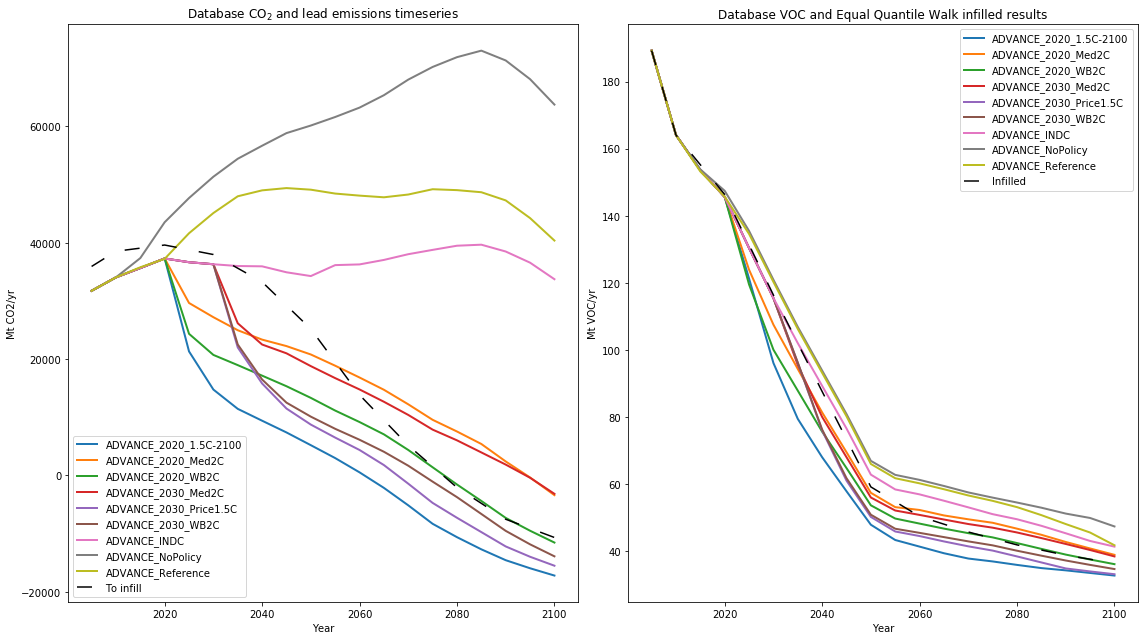

In [11]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_data.filter(variable="*CO2").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill"
)
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
EQW_infilled.filter(variable="*VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled"
)
ax.set_title("Database VOC and Equal Quantile Walk infilled results")

plt.tight_layout()

However the philosophy behind this cruncher is odd, because it ignores the structure of the relationship between the lead and follow data. It assumes that the relationship between them is monotonically ascending at any given time. Below we plot the actual relationship between values, and the relationship implied at our case. Here the fit implies a much stronger relationship than the data justifies.

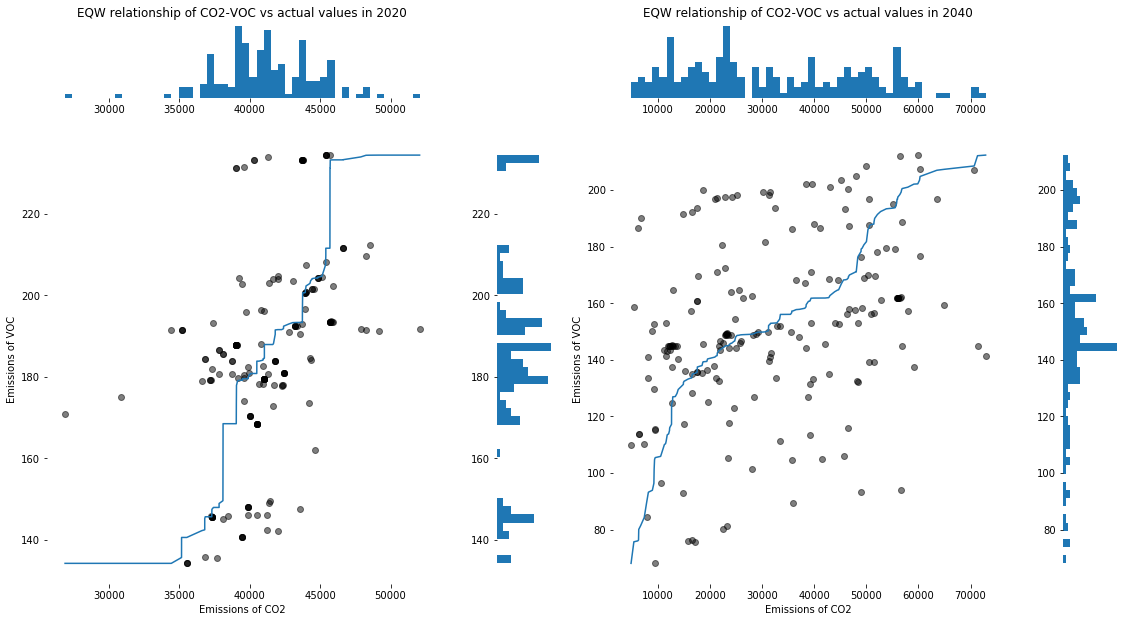

In [12]:
fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(2, 4, width_ratios=[7, 1, 7, 1], height_ratios=[1, 6])

for i, year_of_interest in enumerate([2020, 2040]):
    ax = plt.subplot(gs[1, 2 * i], frameon=False)

    seaborn_df = sr15_data.filter(
        variable=["Emissions|CO2", "Emissions|VOC"], year=year_of_interest
    ).pivot_table(
        ["year", "model", "scenario", "region"], ["variable"], aggfunc="mean"
    )

    # Cleaning the data
    seaborn_df.replace(r"^\s*$", np.nan, regex=True, inplace=True)
    seaborn_df = seaborn_df.dropna().reset_index()
    colours_for_plot = "black"
    ax.scatter(
        x=lead[0], y=follow, color=colours_for_plot, data=seaborn_df, alpha=0.5
    )
    ax.set_xlabel("Emissions of {}".format(lead[0].split("|")[-1]))
    ax.set_ylabel("Emissions of {}".format(follow.split("|")[-1]))
    ax.plot(sorted(seaborn_df[lead[0]]), sorted(seaborn_df[follow]))

    axt = plt.subplot(gs[0, 2 * i], frameon=False, sharex=ax, yticks=[])
    axt.hist(
        seaborn_df[lead[0]], orientation="vertical", density=True, bins=50
    )

    axr = plt.subplot(gs[1, 2 * i + 1], frameon=False, sharey=ax, xticks=[])
    axr.hist(
        seaborn_df[follow], orientation="horizontal", density=True, bins=50
    )

    axt.set_title(
        "EQW relationship of CO2-VOC vs actual values in {}".format(
            year_of_interest
        )
    )

fig.tight_layout(pad=2)

# Extend latest time quantile
This a cruncher that uses the same approach as the Equal Quantile Walk but is used in cases where the target data ends too soon. Instead of using one type of emission to infer the behaviour of another emission, we use the emission data at the final timepoint to infer the emissions after that point, up until the end of the data in the infiller database. 

Imagine we have a scenario that only has data up until 2030:

In [13]:
short_filler_data = filler_data.filter(year=[2005, 2010, 2020, 2030])

And want to extend the CO2 pathway to 2100:

In [14]:
cruncher = silicone.database_crunchers.ExtendLatestTimeQuantile(
    sr15_data_quantile
)
# Only one argument (the emission name) needed in derive relationship
filler = cruncher.derive_relationship("Emissions|CO2")
extension = filler(short_filler_data)

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.


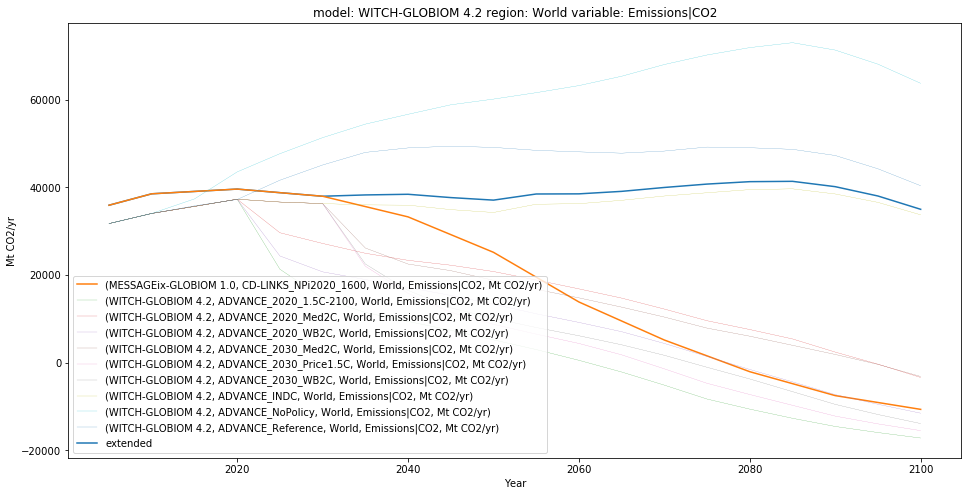

In [15]:
extended_df = short_filler_data.append(extension)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
extended_df.line_plot(ax=ax, label="extended")
filler_data.line_plot(ax=ax)
sr15_data_quantile.filter(variable="Emissions|CO2").line_plot(
    ax=ax, linewidth=0.2
)

As this plot shows, the assumption that the scenario will remain in a constant position relative to the other scenarios is strongly violated here. Better results might be obtained if we used scenarios with more similar trajectories.  

# Quantile Rolling Windows cruncher

This cruncher is best for use in larger databases. It calculates a given quantile of the relationship between lead and follow data in the infiller database, then infills the corresponding value for the infillee data. By default this quantile is 0.5, i.e. we infill the median value. Using higher values (up to 1) will result in higher emissions of the gas being infilled. It is the only cruncher that can generate a distribution of values rather than simply the best estimate. 

The documentation describes how it works: 

In [16]:
print(silicone.database_crunchers.QuantileRollingWindows.__doc__)


    Database cruncher which uses the 'rolling windows' technique.

    This cruncher derives the relationship between two variables by performing
    quantile calculations between the follower timeseries and the lead timeseries.
    These calculations are performed at each timestep in the timeseries, independent
    of the other timesteps.

    For each timestep, the lead timeseries axis is divided into multiple evenly spaced
    windows (to date this is only tested on 1:1 relationships but may work with more
    than one lead timeseries). In each window, every data point in the database is
    included. However, the data points receive a weight given by

    .. math::

        w(x, x_{\text{window}}) = \frac{1}{1 + (d_n)^2}

    where :math:`w` is the weight and :math:`d_n` is the normalised distance between
    the centre of the window and the data point's position on the lead timeseries axis.

    :math:`d_n` is calculated as

    .. math::

        d_n = \frac{x - x_{\text{window}

The diagram below illustrates what these calculated quantiles look like. You may find it instructive to vary `nwindows` and `decay_length_factor`. (The details of the data manipulation in this step are not generally interesting, except for the `rolling_window_find_quantiles` part.)

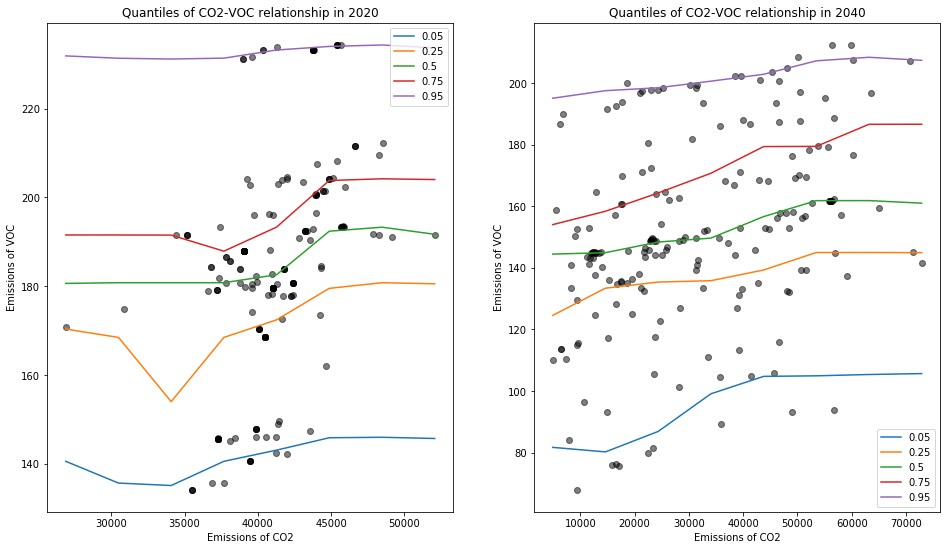

In [17]:
fig = plt.figure(figsize=(16, 9))
i = 1
for year_of_interest in [2020, 2040]:
    seaborn_df = sr15_data.filter(
        variable=["Emissions|CO2", "Emissions|VOC"], year=year_of_interest
    ).pivot_table(
        ["year", "model", "scenario", "region"], ["variable"], aggfunc="mean"
    )
    ax = fig.add_subplot(1, 2, i)
    i += 1
    # Cleaning the data
    seaborn_df.replace(r"^\s*$", np.nan, regex=True, inplace=True)
    seaborn_df = seaborn_df.dropna().reset_index()
    colours_for_plot = "black"
    plt.scatter(
        x=lead[0], y=follow, color=colours_for_plot, data=seaborn_df, alpha=0.5
    )
    plt.xlabel("Emissions of {}".format(lead[0].split("|")[-1]))
    plt.ylabel("Emissions of {}".format(follow.split("|")[-1]))
    ax.set_title(
        "Quantiles of CO2-VOC relationship in {}".format(year_of_interest)
    )
    # The quant_df calculation below may be instructive to modify:
    quant_df = rolling_window_find_quantiles(
        seaborn_df[lead[0]],
        seaborn_df[follow],
        [0.05, 0.25, 0.5, 0.75, 0.95],
        nwindows=8,  # lower than default (11) windows (less noise / pattern)
        decay_length_factor=2,  # Higher than default (1) smoothing (less noise/pattern)
    )
    plt.plot(quant_df.index, quant_df)
    ax.legend([0.05, 0.25, 0.5, 0.75, 0.95])

## Infilling

This method only returns values found in the database (unless `use_ratio` is `True`), so will produce more variation the more data it is given. In most cases we will not want to change the quantile from 0.5. 

In [18]:
cruncher = silicone.database_crunchers.QuantileRollingWindows(
    sr15_data_quantile
)
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.



            Filler function derived from :class:`QuantileRollingWindows`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                The key db_times for filling are not in ``in_iamdf``.
            


Now we can infill a scenario. Once again we will choose model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600" and use the framework from before. 

In [19]:
filled = filler(filler_data)
filled.head()

,model,scenario,region,variable,unit,year,value
0,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2005,189.212000
1,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2010,164.056724
2,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2020,145.611005
3,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2030,115.465871
4,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2040,86.915793


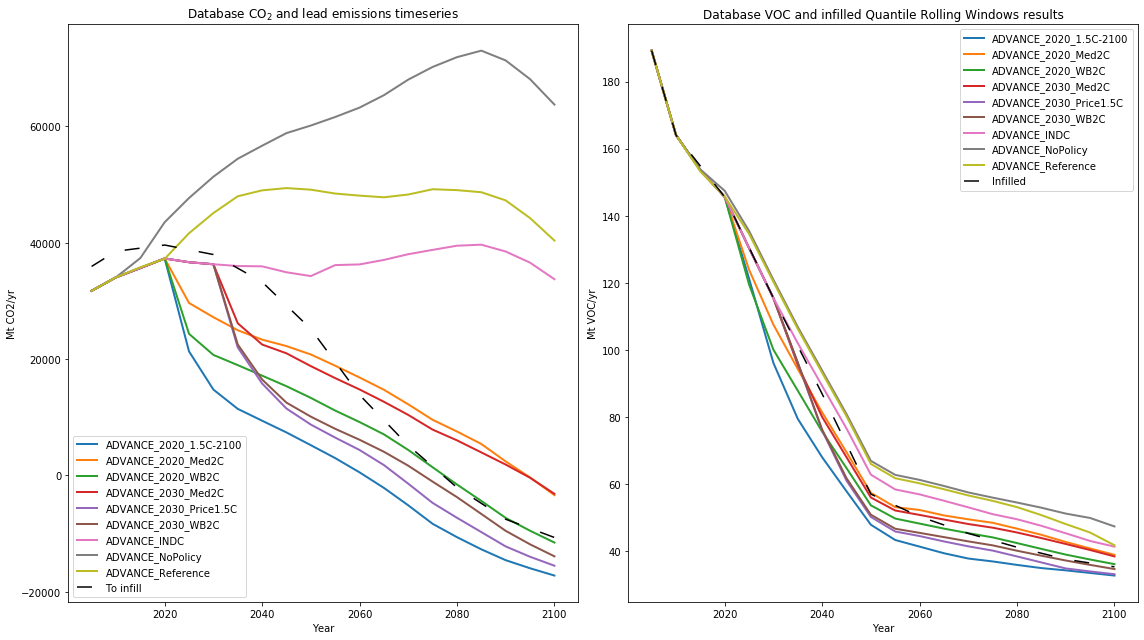

In [20]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_data.filter(variable="*CO2").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill"
)
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
filled.filter(variable="*VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled"
)
ax.set_title("Database VOC and infilled Quantile Rolling Windows results")

plt.tight_layout()

The quantiles do not stick to a single timeline, so unlike in the RMS closest cruncher, we can move between different values found in the infiller database. However we still cannot return values outside of the distribution of inputs, unless we use this cruncher in ratio mode. 

## Recovering the data you put in

This section does not illustrate new functionality, merely investigates the mathematical effects of changing the number of windows.

Because of the averaging mechanism, the cruncher will only precisely reproduce the input data when there is only one timeseries in the infiller database. With multiple data series, this is not guaranteed, although will happen in the limit case of very localised weighting, represented by changing either `nwindows` or `decay_length_factor`. Both of these refer to how the rolling windows are calculated. The first of these controls how many points the windows are calculated at, the second weights points closer to the window center more strongly. The mathematical details can be found in the documentation, but we generally do not advise changing `decay_length_factor`. We explore below the effects of using the whole database on the infiller. 

In [21]:
# Multiple data are input - the 50th percentile and nwindows=10 is the default
filler_data = sr15_data_quantile.filter(scenario="ADVANCE_2030_Med2C")
self_cruncher = silicone.database_crunchers.QuantileRollingWindows(sr15_data)
self_filler_default = self_cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|VOC"], nwindows=10
)
infilled_quantile = self_filler_default(filler_data)

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.


The default behaviour shows the correct trend, but the windows-based interpolation introduces some noise.

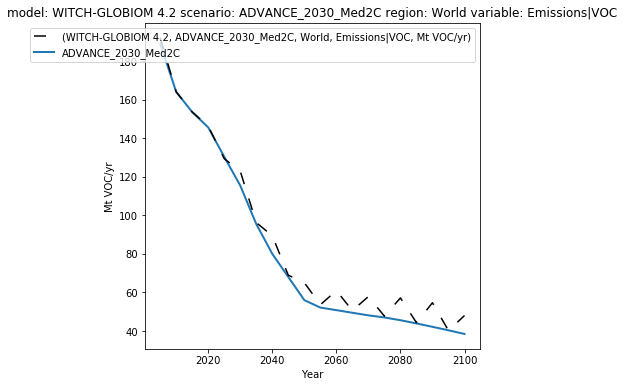

In [22]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
filler_data.filter(variable="Emissions|VOC",).line_plot(ax=ax, **pkwargs)
infilled_quantile.filter(variable="Emissions|VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(8, 10)
)
# To see all the infiller data, uncomment the line below:
# sr15_data.filter(variable='Emissions|VOC',).line_plot(ax=ax, linewidth=0.1)

By increasing the windows number, we can get a higher fidelity - at the cost of more computational power and less averaging over different datapoints (i.e. potentially more spiky behaviour). 

In [23]:
# With a lower window number, the deviations become clearer
self_filler_low_w = self_cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|VOC"], nwindows=2
)
infilled_low_w = self_filler_low_w(filler_data)
# Higher window numbers mean that we weight data with the exact same x-value more highly, recovering the original relation
self_filler_high_w = self_cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|VOC"], nwindows=30
)
infilled_high_w = self_filler_high_w(filler_data)

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.


Here the lower window count (blue) results in large deviations from the local data (towards to median value at that time) whereas the high window case (red) provides a close match. If you want to see all the trend lines on the graph at the same time, uncomment a line below. 

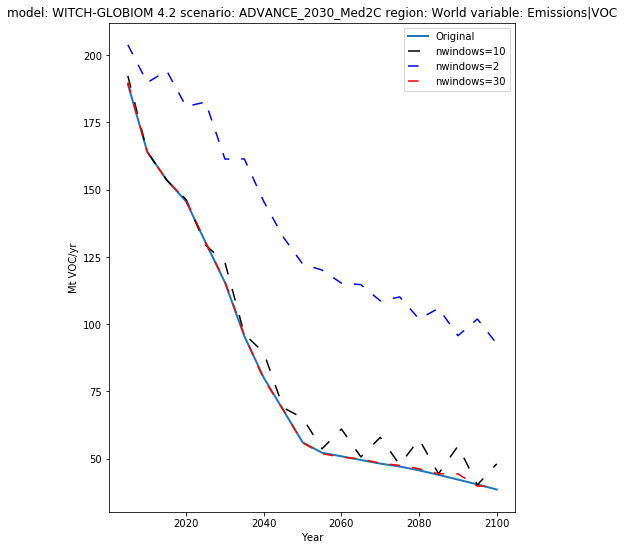

In [24]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
filler_data.filter(variable="Emissions|VOC",).line_plot(ax=ax, **pkwargs)
infilled_quantile.filter(variable="Emissions|VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(8, 10)
)
infilled_low_w.line_plot(ax=ax, color="blue", linestyle="--", dashes=(7, 8))
infilled_high_w.line_plot(ax=ax, color="red", linestyle="--", dashes=(7, 8))
plt.legend(["Original", "nwindows=10", "nwindows=2", "nwindows=30"])
# This line illustrates the background data informing the deviations (but confuses the plots).
# Re-add it if desired:
# sr15_data.filter(variable='Emissions|VOC',).line_plot(ax=ax, linewidth=0.1)

#### Quantile rolling window ratio option
The quantile rolling window infiller has a `use_ratio` option that defaults to false. If set to true, instead of infilling the value found using the above process, it uses the ratio between the lead and follow data. This ratio is found using rolling weighted windows as above, and is typically the median value. Having found the ratio, it multiplies it by the value of the lead variable in the infillee database at the appropriate time. We recommend not to use this if the lead or follow variable changes sign. 

In [25]:
filler_input = sr15_data.filter(
    model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600"
)
filler_data = filler_input.filter(
    year=sr15_data_quantile["year"].unique(), variable="Emissions|CO2"
)
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], use_ratio=True
)
infilled = filler(filler_data)

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.


Note that the lead variable ['Emissions|CO2'] goes negative.


The graphs below show that these results are also reasonable, and allow for infilled values outside the range in the infiller database. However there is some degree of irregularity when the lead variable goes negative, and potentially a sign error could occur here. 

Text(0.5, 1.0, 'Database VOC and filled follower emissions timeseries')

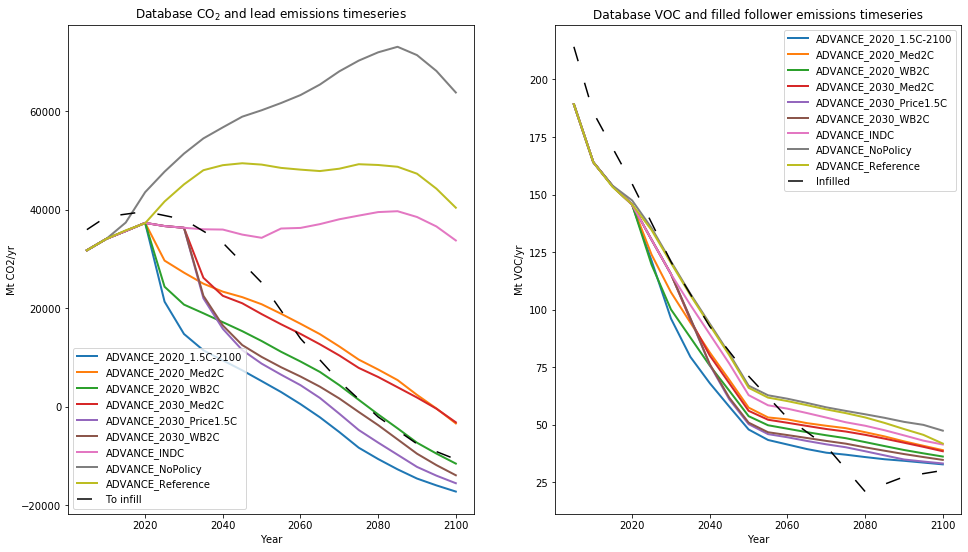

In [26]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_data.filter(variable="*CO2").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill"
)
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
infilled.filter(variable="*VOC").line_plot(
    ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled"
)
ax.set_title("Database VOC and filled follower emissions timeseries")

## Other quantiles
Using quantiles other than 0.5 is possible, but needs to be done with caution. Note that a higher quantile always corresponds to a higher level of emissions, even if the lead and follow emissions type may anticorrelate (e.g. SF6 emissions may increase as CO2 emissions decrease). This means that crunching many variables with the same quantile (not 0.5) will introduce additional correlation between these. The main use-case is with a randomly generated or portfolio of values (independent for each gas infilled) to generate a portfolio of possible pathways. 

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attrib

Text(0.5, 1.0, 'VOC when infilling with different quantiles, default window parameters')

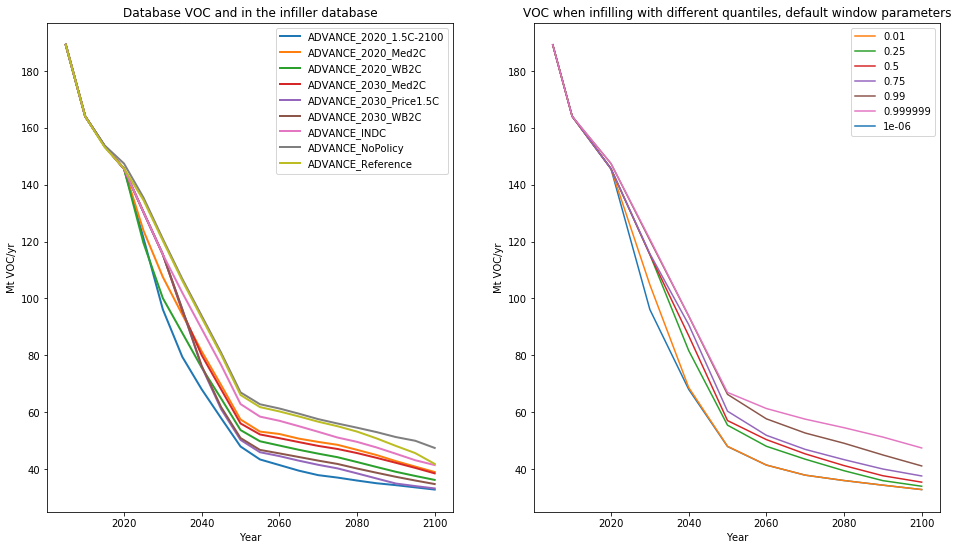

In [27]:
all_quant = [1e-6, 0.01, 0.25, 0.5, 0.75, 0.99, 1 - 1e-6]
all_infilled = []
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
ax.set_title("Database VOC and in the infiller database")
ax = fig.add_subplot(122)
for quant in all_quant:
    filler = cruncher.derive_relationship(
        "Emissions|VOC", ["Emissions|CO2"], quantile=quant
    )
    all_infilled.append(filler(filler_data))
    all_infilled[-1].filter(variable="*VOC").line_plot(ax=ax, label=quant)
ax.set_title(
    "VOC when infilling with different quantiles, default window parameters"
)

Here we see that for sufficiently extreme quantiles, we will reconstruct the whole range of possible values, however even the top and bottom 0.01 do not reach the most extreme values, since the spread of lead variables is very large. To have more representation from distant values of the lead variables, we can decrease the `decay_length_factor`. Larger values of this means a slower roll-off of the rolling window, so more extreme outputs are accessed at less extreme quantiles. With decay length 100, below, we see that there is no longer a difference between 0.01 and 0.000001 quantiles. 

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attrib

Text(0.5, 1.0, 'VOC when infilling with different quantiles, decay_length_factor=100')

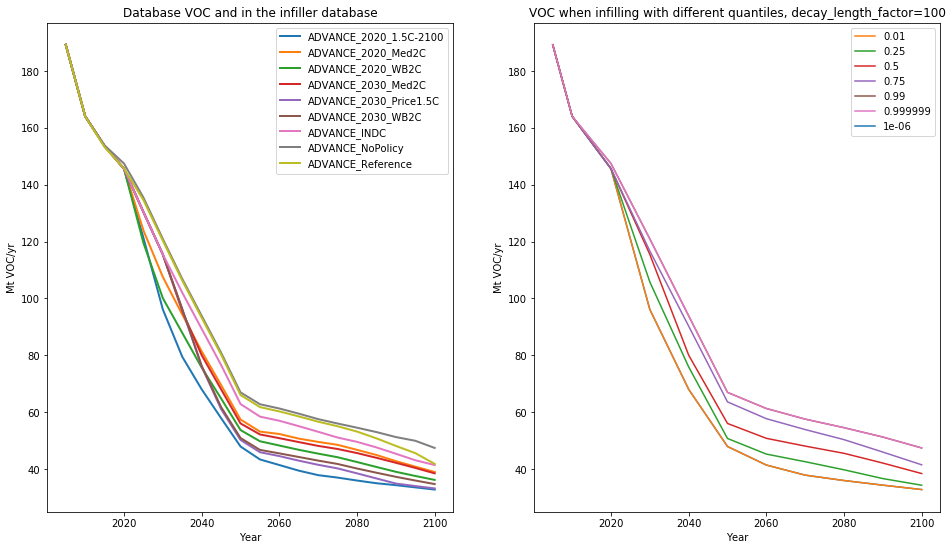

In [28]:
all_quant = [1e-6, 0.01, 0.25, 0.5, 0.75, 0.99, 1 - 1e-6]
all_infilled = []
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
ax.set_title("Database VOC and in the infiller database")
ax = fig.add_subplot(122)
for quant in all_quant:
    filler = cruncher.derive_relationship(
        "Emissions|VOC",
        ["Emissions|CO2"],
        quantile=quant,
        decay_length_factor=100,
    )
    all_infilled.append(filler(filler_data))
    all_infilled[-1].filter(variable="*VOC").line_plot(ax=ax, label=quant)
ax.set_title(
    "VOC when infilling with different quantiles, decay_length_factor=100"
)

# Time-dependent quantile rolling windows
This technique allows the same behaviour as quantile rolling windows, but with different quantiles at each time. It is designed for use by IAM teams who have reasons to believe that the relationship between two variables might differ from the normal expectations in a time-dependent way, e.g. if CO2 cuts were obtained by some industry that releases large quantities of VOCs, starting in around 20 years. Most of the inputs to this cruncher are the same as in the standard Quantile Rolling Windows cruncher, with the exception of the {time: quantile} dictionary, which tells the cruncher which quantile to use at which time. There is no default on this, and times not included in this dictionary will not be infilled. 

In [29]:
time_quant = {
    2010: 0.5,
    2020: 0.5,
    2030: 0.6,
    2040: 0.6,
    2050: 0.8,
    2060: 0.9,
    2070: 0.9,
    2080: 0.9,
    2090: 0.9,
    2100: 0.9,
}

In [30]:
cruncher = silicone.database_crunchers.TimeDepQuantileRollingWindows(
    sr15_data_quantile
)
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], time_quantile_dict=time_quant
)
filler_d10 = cruncher.derive_relationship(
    "Emissions|VOC",
    ["Emissions|CO2"],
    time_quantile_dict=time_quant,
    decay_length_factor=10,
)

pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attribute `variable` instead.
pyam.logging - WARNING: This method is deprecated and will be removed in future versions. Use the attrib

This infiller requires every year to be infilled to have a value in the dictionary

In [31]:
try:
    infilled = filler(filler_data)
except ValueError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: Not all required times in the infillee database can be found in the dictionary.


In [32]:
set(filler_data["year"]) - set(time_quant.keys())

{2005}

We could add a value for 2005 to the dictionary, but for now let's suppose we aren't interested in it

In [33]:
filler_data = filler_data.filter(year=2005, keep=False)
infilled = filler(filler_data)
infilled_d10 = filler_d10(filler_data)
infilled.data.head()

,model,scenario,region,variable,unit,year,value
0,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2010,164.056724
1,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2020,145.611005
2,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2030,115.465871
3,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2040,88.972685
4,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2050,61.302323


Text(0.5, 1.0, 'VOC when infilling with different quantiles in different years')

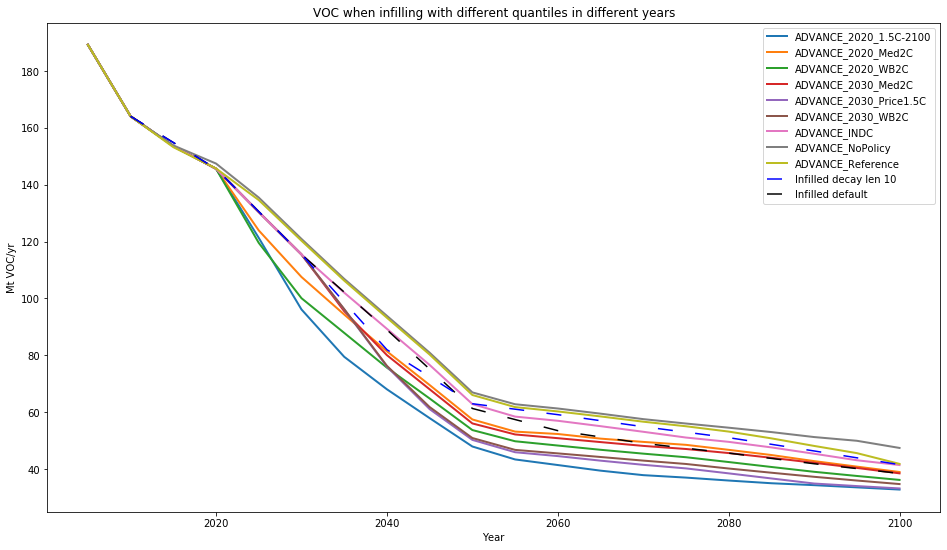

In [34]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
infilled.line_plot(
    ax=ax,
    label="Infilled default",
    color="black",
    linestyle="--",
    dashes=(10, 15),
)
infilled_d10.line_plot(
    ax=ax,
    label="Infilled decay len 10",
    color="blue",
    linestyle="-.",
    dashes=(10, 15),
)
ax.set_title("VOC when infilling with different quantiles in different years")

We can see that the infilled pathway moves through the range of possibilities. Note that we have used a decay_length_factor of 10 to average over a wider lead variable and therefore see a larger change. 